In [11]:

import cv2
import numpy as np
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

img = mpimg.imread('/home/shaxpy/Downloads/Search and Sample bot/2.jpg')

def perspect_transform(img,src,dst):
    m=cv2.getPerspectiveTransform(src,dst)
    warped=cv2.warpPerspective(img,m,(img.shape[1],img.shape[0]))
    return warped
sze=5
bottom=6
source=np.float32([[14,139],[301,140],[200,96],[118,96]])
dest=np.float32([[img.shape[1]/2-sze,img.shape[0]-bottom],
                 [img.shape[1]/2+sze,img.shape[0]-bottom],
                 [img.shape[1]/2+sze,img.shape[0]- 2*sze-bottom],
                 [img.shape[1]/2-sze,img.shape[0]- 2*sze-bottom],])

warped=perspect_transform(img,source,dest)
colorsel = color_thresh(warped, rgb_thresh=(160, 160, 160))


def color_thresh(img, rgb_thresh=(0, 0, 0)):
    color_select = np.zeros_like(img[:,:,0])
    above= (img[:,:,0]>rgb_thresh[0])             & (img[:,:,1] > rgb_thresh[1])             & (img[:,:,2] > rgb_thresh[2])
    color_select[above] = 1
    return color_select
    
# Define color selection criteria
red_threshold = 160
green_threshold = 160
blue_threshold = 160
######
rgb_threshold = (red_threshold, green_threshold, blue_threshold)



def rover_coords(binary_img):
    # Extract xpos and ypos pixel positions from binary_img and
    ypos, xpos = binary_img.nonzero()
    # Convert xpos and ypos to rover-centric coordinates
    x_pixel = -(ypos - binary_img.shape[0]).astype(np.float)
    y_pixel = -(xpos - binary_img.shape[1]/2 ).astype(np.float)
    return x_pixel, y_pixel
xpix, ypix = rover_coords(colorsel)



In [12]:
# from extra_functions import perspect_transform, color_thresh, rover_coords


# Rover yaw values will come as floats from 0 to 360
# Generate a random value in this range
# Note: you need to convert this to radians
    # before adding to pixel_angles
rover_yaw = np.random.random(1)*360

# Generate a random rover position in world coords
# Position values will range from 20 to 180 to 
# avoid the edges in a 200 x 200 pixel world
rover_xpos = np.random.random(1)*160 + 20
rover_ypos = np.random.random(1)*160 + 20

# Note: Since we've chosen random numbers for yaw and position, 
# multiple run of the code will result in different outputs each time.




## Rotation

In [17]:
# Define a function to apply a rotation to pixel positions
def rotate_pix(xpix, ypix, yaw): 
    # Convert yaw to radians
    yaw=yaw * np.pi/180
    # Apply a rotation by rotation matrix
    xpix_rotated = xpix*np.cos(yaw) - ypix*np.sin(yaw)
    ypix_rotated = xpix*np.sin(yaw) + ypix*np.cos(yaw)
    # Return the result  
    return xpix_rotated, ypix_rotated


## Scaling and Translation

In [20]:
# Define a function to perform a translation
def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # Apply a scaling and a translation
    scale = 10
    xpix_translated = np.int_(xpos + (xpix_rot / scale))
    ypix_translated = np.int_(ypos + (ypix_rot / scale))
    # Return the result  
    return xpix_translated, ypix_translated



Xpos = [164.00972996] Ypos = [59.1760695] Yaw = [174.6903608]


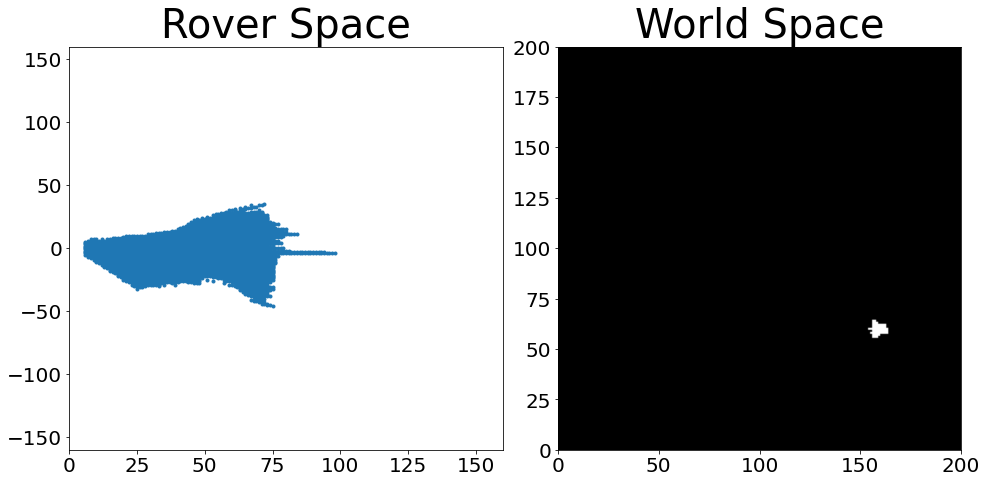

In [22]:
# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Clip to world_size like (mapping functions)
    world_size = 200
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world

# Perform warping and color thresholding
##########

# Define calibration box in source (actual) and destination (desired) coordinates
# These source and destination points are defined to warp the image
# to a grid where each 10x10 pixel square represents 1 square meter
dst_size = 5 
# Bottom offset to account for the fact that the bottom of the image 
# is not the position of the rover but a bit in front of it
bottom_offset = 6
source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                  [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                  ])
warped = perspect_transform(image, source, destination)
colorsel = color_thresh(warped, rgb_thresh=(160, 160, 160))
# Extract navigable terrain pixels
xpix, ypix = rover_coords(colorsel)
# Generate 200 x 200 pixel worldmap
worldmap = np.zeros((200, 200))
scale = 10
# Get navigable pixel positions in world coords
x_world, y_world = pix_to_world(xpix, ypix, rover_xpos, 
                                rover_ypos, rover_yaw, 
                                worldmap.shape[0], scale)
# Add pixel positions to worldmap
worldmap[y_world, x_world] += 1
print('Xpos =', rover_xpos, 'Ypos =', rover_ypos, 'Yaw =', rover_yaw)
# Plot the map in rover-centric coords

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
f.tight_layout()
ax1.plot(xpix, ypix, '.')
ax1.set_title('Rover Space', fontsize=40)
ax1.set_ylim(-160, 160)
ax1.set_xlim(0, 160)
ax1.tick_params(labelsize=20)

ax2.imshow(worldmap, cmap='gray')
ax2.set_title('World Space', fontsize=40)
ax2.set_ylim(0, 200)
ax2.tick_params(labelsize=20)
ax2.set_xlim(0, 200)


plt.subplots_adjust(left=0.1, right=1, top=0.9, bottom=0.1)
plt.show() 